# 路径

In [1]:
import os
import sys
root=os.path.abspath(os.path.join(r"D:\project_meta\NNproject\NNI"))
print(root)
sys.path.append(root)
os.environ["TORCH_HOME"]=r"E:\Data\torch-model"
import warnings  
warnings.filterwarnings("ignore", category=RuntimeWarning, module="mne")


D:\project_meta\NNproject\NNI


# Dataset

In [6]:
import torch
from project.dataset.SelfDataset import TableControlFullLoadDataset
from project.dataprocess import FolderTree
import pandas as pd
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, Subset, SubsetRandomSampler


In [7]:
from torch.utils.data import Dataset
import pandas as pd
from typing import Any
class TableDataset(Dataset):
    def __init__(self,table:pd.DataFrame) -> None:
        super().__init__()
        self.Table=table
    def __len__(self):
        return len(self.Table)
    def __getitem__(self, index) -> Any:
        return self.Table.iloc[index].to_dict()
        

In [8]:
#路径
data_root=r'D:\dataset\driver_dataset\DROZY\DROZY'
output_root=r"D:\project_meta\NNproject\NNI\output"

data_path_dict=FolderTree.getDataPath(data_root=data_root)
output_path_dic=FolderTree.getOutPath(output_root=output_root)

#表
bandPowerTable=pd.read_csv(r"D:\project_meta\NNproject\NNI\output\bandpoweruniform.csv")
#数据集分割
trainDataTable,testDataTable=train_test_split(bandPowerTable,test_size=0.35,shuffle=True)

#数据加载器
train_dataset=TableDataset(trainDataTable)
train_dataloader=DataLoader(train_dataset,batch_size=512,shuffle=True)

test_dataset=TableDataset(testDataTable)
test_dataloader=DataLoader(test_dataset,batch_size=512)


In [9]:
batch=next(iter(train_dataloader))
print(batch.keys())
for colum in batch.keys():
    print(colum,len(batch[colum]))

dict_keys(['Fz_delta', 'Fz_theta', 'Fz_alpha', 'Fz_beta', 'Fz_gamma', 'Cz_delta', 'Cz_theta', 'Cz_alpha', 'Cz_beta', 'Cz_gamma', 'C3_delta', 'C3_theta', 'C3_alpha', 'C3_beta', 'C3_gamma', 'C4_delta', 'C4_theta', 'C4_alpha', 'C4_beta', 'C4_gamma', 'Pz_delta', 'Pz_theta', 'Pz_alpha', 'Pz_beta', 'Pz_gamma', 'ID', 'LEVEL', 'KSS'])
Fz_delta 512
Fz_theta 512
Fz_alpha 512
Fz_beta 512
Fz_gamma 512
Cz_delta 512
Cz_theta 512
Cz_alpha 512
Cz_beta 512
Cz_gamma 512
C3_delta 512
C3_theta 512
C3_alpha 512
C3_beta 512
C3_gamma 512
C4_delta 512
C4_theta 512
C4_alpha 512
C4_beta 512
C4_gamma 512
Pz_delta 512
Pz_theta 512
Pz_alpha 512
Pz_beta 512
Pz_gamma 512
ID 512
LEVEL 512
KSS 512


In [6]:
pd.DataFrame(batch).shape

(512, 28)

# MLP 模型

In [10]:
import torch.nn as nn
def getMlp(numFeature,interWidth,classes):
    interWidth.insert(0,numFeature)
    interWidth.append(classes)
    net=nn.Sequential()
    for i in range(len(interWidth)-2) :
        net.append(nn.Linear(interWidth[i],interWidth[i+1]))
        #net.append(nn.Dropout(0.5))
        net.append(nn.ReLU())
    net.append(nn.Linear(interWidth[-2],interWidth[-1]))
    return net
    pass

In [11]:
from torchsummary import summary
InterWidth=[32,64,16]
NumFeature=pd.DataFrame(batch).drop(columns=['ID','LEVEL','KSS']).shape[-1]
classes=3
print(f'数据维度：{NumFeature}\n类别数：{classes}')

print("InterWidth",InterWidth)

net=getMlp(numFeature=NumFeature,interWidth=InterWidth,classes=classes)
print(net)
summary(net,(1,NumFeature),batch_size=5,device='cpu')

数据维度：25
类别数：3
InterWidth [32, 64, 16]
Sequential(
  (0): Linear(in_features=25, out_features=32, bias=True)
  (1): ReLU()
  (2): Linear(in_features=32, out_features=64, bias=True)
  (3): ReLU()
  (4): Linear(in_features=64, out_features=16, bias=True)
  (5): ReLU()
  (6): Linear(in_features=16, out_features=3, bias=True)
)
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                 [5, 1, 32]             832
              ReLU-2                 [5, 1, 32]               0
            Linear-3                 [5, 1, 64]           2,112
              ReLU-4                 [5, 1, 64]               0
            Linear-5                 [5, 1, 16]           1,040
              ReLU-6                 [5, 1, 16]               0
            Linear-7                  [5, 1, 3]              51
Total params: 4,035
Trainable params: 4,035
Non-trainable params: 0
------------------------------

In [ ]:
#InterWidth=[128,512,64,3]

In [1]:
from d2l import torch as d2l
import torch.nn as nn 
import torch.nn.functional as F
import torch
from torchsummary import summary
import datetime


device=torch.device('cuda')
current_time = datetime.datetime.now()
formatted_time = current_time.strftime("%Y_%m_%d_%H_%M_%S")
parameterFolder=os.path.join(r"D:\project_meta\NNproject\NNI\output\model_parameter\FilterSignalCNN1D",f"{formatted_time}")
print(parameterFolder)
os.makedirs(parameterFolder)
InterWidth=[128,512,64,3]
NumFeature=pd.DataFrame(batch).drop(columns=['ID','LEVEL','KSS']).shape[-1]
classes=3
print(f'数据维度：{NumFeature}\n类别数：{classes}')

print("InterWidth",InterWidth)

net=getMlp(numFeature=NumFeature,interWidth=InterWidth,classes=classes)
print(net)
summary(net,(1,NumFeature),batch_size=5,device='cpu')



animator = d2l.Animator(xlabel='epoch',
                        legend=['train_acc','test_acc'])   
num_batches = len(train_dataloader)
best_train_acc=0
best_train_loss=0
best_test_acc=0
stagnate_times=0
temp_acc=0

num_epochs=2000
net.to(device)
optim=torch.optim.SGD(net.parameters(),lr=0.07,weight_decay=5e-4)#,weight_decay=5e-4
loss=nn.CrossEntropyLoss()
for epoch in range(num_epochs):
    metric_train = d2l.Accumulator(2)
    net.train()
    for i,data in enumerate(train_dataloader):
        #print(data)

        optim.zero_grad()

        pddata=pd.DataFrame(data)
        x=pddata.drop(columns=['ID','KSS','LEVEL']).values
        x=torch.tensor(x).unsqueeze(1).to(torch.float32).to(device)
        # print(x.shape)
        y_hat=net(x)
        y_hat=torch.squeeze(y_hat, dim=1)
        y=torch.tensor(pddata['LEVEL'].values)-1
        y=y.long().to(device)  
        print(y.shape,y_hat.shape)     
        l=loss(y_hat, y)
        l.backward()
        optim.step()
        pre=torch.argmax(y_hat.detach().cpu(),dim=1)
        num_true=sum(pre==y.cpu())
        metric_train.add(num_true,y.numel())
        if (i + 1) % (num_batches // 2) == 0 or i == num_batches - 1:
            animator.add(epoch + (i + 1) / num_batches, (metric_train[0]/metric_train[1],None))
        if best_train_acc<(metric_train[0]/metric_train[1]):
            best_train_acc=metric_train[0]/metric_train[1]
            stagnate_times=0
            torch.save(net.state_dict(),os.path.join(parameterFolder,f'{best_train_acc}.pt'))

        
    net.eval()
    metric_test = d2l.Accumulator(2)
    with torch.no_grad():
        testnum_batches = len(test_dataloader)
        for data_dict in test_dataloader:

            pddata=pd.DataFrame(data)
            x=pddata.drop(columns=['ID','KSS','LEVEL']).values
            x=torch.tensor(x).unsqueeze(1).to(torch.float32).to(device)
            # print(x.shape)
            y_hat=net(x)
            y_hat=torch.squeeze(y_hat, dim=1)
            y=torch.tensor(pddata['LEVEL'].values)-1
            y=y.long().to(device)
        
            pre=torch.argmax(y_hat.detach().cpu(),dim=1)
            num_true=sum(pre==y.cpu())
            metric_test.add(num_true,y.numel())
            animator.add(epoch+ (i + 1) / num_batches, (None,metric_test[0]/metric_test[1]))

    

    
    pass

NameError: name 'os' is not defined

KeyboardInterrupt: 

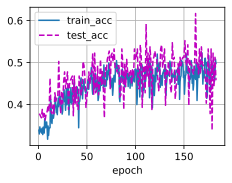

In [23]:
from d2l import torch as d2l
import torch.nn as nn 
import torch.nn.functional as F
import torch

from torchsummary import summary
device=torch.device('cuda')
import datetime
current_time = datetime.datetime.now()
formatted_time = current_time.strftime("%Y_%m_%d_%H_%M_%S")
parameterFolder=os.path.join(r"D:\project_meta\NNproject\NNI\output\model_parameter\FilterSignalCNN1D",f"{formatted_time}")
print(parameterFolder)
os.makedirs(parameterFolder)
InterWidth=[256,512,64,3]
NumFeature=pd.DataFrame(batch).drop(columns=['ID','LEVEL','KSS']).shape[-1]
classes=3
print(f'数据维度：{NumFeature}\n类别数：{classes}')

print("InterWidth",InterWidth)

net=getMlp(numFeature=NumFeature,interWidth=InterWidth,classes=classes)
print(net)
summary(net,(1,NumFeature),batch_size=5,device='cpu')



animator = d2l.Animator(xlabel='epoch',
                        legend=['train_acc','test_acc'])   
num_batches = len(train_dataloader)
best_train_acc=0
best_train_loss=0
best_test_acc=0
stagnate_times=0
temp_acc=0


In [27]:

num_epochs=2000
net.to(device)
optim=torch.optim.SGD(net.parameters(),lr=0.001,weight_decay=5e-4)#,weight_decay=5e-4
loss=nn.CrossEntropyLoss()
for epoch in range(num_epochs):
    metric_train = d2l.Accumulator(2)
    net.train()
    for i,data in enumerate(train_dataloader):
        #print(data)

        optim.zero_grad()

        pddata=pd.DataFrame(data)
        x=pddata.drop(columns=['ID','KSS','LEVEL']).values
        x=torch.tensor(x).unsqueeze(1).to(torch.float32).to(device)
        # print(x.shape)
        y_hat=net(x)
        y_hat=torch.squeeze(y_hat, dim=1)
        y=torch.tensor(pddata['LEVEL'].values)-1
        y=y.long().to(device)       
        l=loss(y_hat, y)
        l.backward()
        optim.step()
        pre=torch.argmax(y_hat.detach().cpu(),dim=1)
        num_true=sum(pre==y.cpu())
        metric_train.add(num_true,y.numel())
        if (i + 1) % (num_batches // 2) == 0 or i == num_batches - 1:
            animator.add(epoch + (i + 1) / num_batches, (metric_train[0]/metric_train[1],None))
        if best_train_acc<(metric_train[0]/metric_train[1]):
            best_train_acc=metric_train[0]/metric_train[1]
            stagnate_times=0
            torch.save(net.state_dict(),os.path.join(parameterFolder,f'{best_train_acc}.pt'))

        
    net.eval()
    metric_test = d2l.Accumulator(2)
    with torch.no_grad():
        testnum_batches = len(test_dataloader)
        for data_dict in test_dataloader:

            pddata=pd.DataFrame(data)
            x=pddata.drop(columns=['ID','KSS','LEVEL']).values
            x=torch.tensor(x).unsqueeze(1).to(torch.float32).to(device)
            # print(x.shape)
            y_hat=net(x)
            y_hat=torch.squeeze(y_hat, dim=1)
            y=torch.tensor(pddata['LEVEL'].values)-1
            y=y.long().to(device)
        
            pre=torch.argmax(y_hat.detach().cpu(),dim=1)
            num_true=sum(pre==y.cpu())
            metric_test.add(num_true,y.numel())
            animator.add(epoch+ (i + 1) / num_batches, (None,metric_test[0]/metric_test[1]))

    

    
    pass

KeyboardInterrupt: 

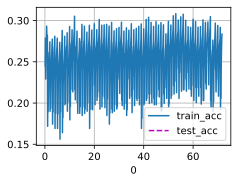

: 

In [ ]:
from d2l import torch as d2l
import torch.nn as nn 
import torch.nn.functional as F
import torch

from torchsummary import summary
from sklearn.model_selection import KFold
import pandas as pd
device=torch.device('cuda')
bandPowerTable=pd.read_csv(r"D:\project_meta\NNproject\NNI\output\bandpower.csv")
kf = KFold(n_splits=10, shuffle=False)
dataset=TableDataset(bandPowerTable)
AnimatorList=[]
for  kf_i,(train_index, val_index) in enumerate(kf.split(dataset)):
    # print(len(train_index))
    # print(train_index)

    # 绘图
    AnimatorList.append( d2l.Animator(xlabel=f'{kf_i}',
                        legend=['train_acc','test_acc']))
    animator=AnimatorList[kf_i]

    #dataset
    train_fold = torch.utils.data.dataset.Subset(dataset, train_index)
    val_fold = torch.utils.data.dataset.Subset(dataset, val_index)    
    
    # 打包成DataLoader类型 用于 训练
    train_loader = DataLoader(dataset=train_fold, batch_size=64, shuffle=False)
    val_loader = DataLoader(dataset=val_fold, batch_size=64, shuffle=False)


    train_size = len(train_loader)
    val_size = len(val_loader)

    num_batches=len(train_loader)

    train_dataloader=train_loader
    test_dataloader=val_loader
    # 开始进行训练
    best_train_acc=0
    best_train_loss=0
    best_test_acc=0
    stagnate_times=0

    # print(train_size)
    # print(val_size)
    # #初始化
    InterWidth=[64,128,64,32]
    NumFeature=pd.DataFrame(batch).drop(columns=['ID','LEVEL','KSS']).shape[-1]
    net=getMlp(numFeature=NumFeature,interWidth=InterWidth,classes=classes)
    net.to(device)
    classes=3
    print(f'数据维度：{NumFeature}\n类别数：{classes}')
    print("InterWidth",InterWidth)
   
    print("训练开始.....")
    
    optim=torch.optim.Adam(net.parameters(),lr=0.001,weight_decay=5e-4)
    loss=nn.CrossEntropyLoss()

    num_batches = len(train_dataloader)
    best_train_acc=0
    best_train_loss=0
    best_test_acc=0
    stagnate_times=0
    temp_acc=0

    num_epochs=500

    for epoch in range(num_epochs):
        metric_train = d2l.Accumulator(2)
        net.train()
        for i,data in enumerate(train_dataloader):
            #print(data)

            optim.zero_grad()

            pddata=pd.DataFrame(data)
            x=pddata.drop(columns=['ID','KSS','LEVEL']).values
            x=torch.tensor(x).unsqueeze(1).to(torch.float32).to(device)
            # print(x.shape)
            y_hat=net(x)
            y_hat=torch.squeeze(y_hat, dim=1)
            y=torch.tensor(pddata['LEVEL'].values)-1
            y=y.long().to(device)

            # print(y_hat.shape)
            # print(y.shape)        
            l=F.cross_entropy(y_hat, y)
            l.backward()
            optim.step()

            pre=torch.argmax(y_hat.detach().cpu(),dim=1)

            num_true=sum(pre==y.cpu())
            metric_train.add(num_true,y.numel())
            if (i + 1) % (num_batches // 10) == 0 or i == num_batches - 1:
                animator.add(epoch + (i + 1) / num_batches, (metric_train[0]/metric_train[1],None))
            
            
    #     net.eval()
    #     metric_test = d2l.Accumulator(2)
    #     with torch.no_grad():
    #         testnum_batches = len(test_dataloader)
    #         for data_dict in test_dataloader:

    #             pddata=pd.DataFrame(data)
    #             x=pddata.drop(columns=['ID','KSS','LEVEL']).values
    #             x=torch.tensor(x).unsqueeze(1).to(torch.float32).to(device)
    #             # print(x.shape)
    #             y_hat=net(x)
    #             y_hat=torch.squeeze(y_hat, dim=1)
    #             y=torch.tensor(pddata['LEVEL'].values)-1
    #             y=y.long().to(device)
            
    #             pre=torch.argmax(y_hat.detach().cpu(),dim=1)
    #             num_true=sum(pre==y.cpu())
    #             metric_test.add(num_true,y.numel())
    #             animator.add(epoch+ (i + 1) / num_batches, (None,metric_test[0]/metric_test[1]))


Sequential(
  (0): Linear(in_features=25, out_features=256, bias=True)
  (1): ReLU()
  (2): Linear(in_features=256, out_features=512, bias=True)
  (3): ReLU()
  (4): Linear(in_features=512, out_features=64, bias=True)
  (5): ReLU()
  (6): Linear(in_features=64, out_features=3, bias=True)
  (7): ReLU()
  (8): Linear(in_features=3, out_features=3, bias=True)
)
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                [5, 1, 256]           6,656
              ReLU-2                [5, 1, 256]               0
            Linear-3                [5, 1, 512]         131,584
              ReLU-4                [5, 1, 512]               0
            Linear-5                 [5, 1, 64]          32,832
              ReLU-6                 [5, 1, 64]               0
            Linear-7                  [5, 1, 3]             195
              ReLU-8                  [5, 1, 3]               

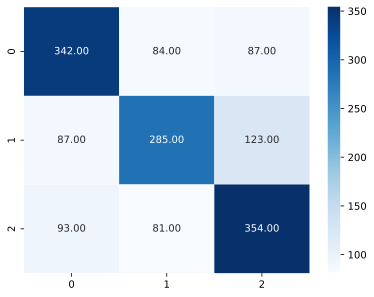

In [38]:

# from sklearn.metrics import confusion_matrix
# import numpy as np
# num_classes=4
# net=simple_cnn1d(input_channels=5,num_classes=10,list_down=[16,32,64,64,64])
# net.to(device)
# confusion_matrix_test = np.zeros((num_classes, num_classes))
# net.load_state_dict(torch.load(r"D:\project_meta\NNproject\NNI\output\model_parameter\FilterSignalCNN1D\2023_11_06_20_20_22\LEVEL0.7866868381240545.pt"))
# for data_dict in test_dataloader:
#     x=data_dict["data"].to(torch.float32).to(device)
#     y=data_dict["LEVEL"].long().to(device)
#     y_hat=net(x)
#     pre=torch.argmax(y_hat.detach().cpu(),dim=1)
#     num_true=sum(pre==y.cpu())
#     y_pred = torch.stack((pre, y.cpu()), dim=1)
#     confusion_matrix_test += confusion_matrix(y_pred[:, 1], y_pred[:, 0], labels=range(num_classes))
# import seaborn as sns

# InterWidth=[256,512,64,3]
# NumFeature=pd.DataFrame(batch).drop(columns=['ID','LEVEL','KSS']).shape[-1]
# classes=3
# print(f'数据维度：{NumFeature}\n类别数：{classes}')

# print("InterWidth",InterWidth)


from sklearn.metrics import confusion_matrix
import numpy as np
num_classes=3
InterWidth=[256,512,64,3]
NumFeature=pd.DataFrame(batch).drop(columns=['ID','LEVEL','KSS']).shape[-1]
classes=3
net=getMlp(numFeature=NumFeature,interWidth=InterWidth,classes=classes)
net.load_state_dict(torch.load(r"D:\project_meta\NNproject\NNI\output\model_parameter\FilterSignalCNN1D\2023_11_11_12_23_58\0.669921875.pt"))
print(net)
summary(net,(1,NumFeature),batch_size=5,device='cpu')
confusion_matrix_test = np.zeros((num_classes, num_classes))
# sns.heatmap(confusion_matrix_test,annot=True, fmt=".2f", cmap="Blues")
net.to(device)

net.eval()
metric_test = d2l.Accumulator(2)
confusion_matrix_test = np.zeros((num_classes, num_classes))
with torch.no_grad():
    testnum_batches = len(test_dataloader)
    for data_dict in test_dataloader:
        pddata=pd.DataFrame(data)
        x=pddata.drop(columns=['ID','KSS','LEVEL']).values
        x=torch.tensor(x).unsqueeze(1).to(torch.float32).to(device)
        y_hat=net(x)
        y_hat=torch.squeeze(y_hat, dim=1)
        y=torch.tensor(pddata['LEVEL'].values)-1
        y=y.long().to(device)
        pre=torch.argmax(y_hat.detach().cpu(),dim=1)
        num_true=sum(pre==y.cpu())
        y_pred = torch.stack((pre, y.cpu()), dim=1)
        confusion_matrix_test += confusion_matrix(y_pred[:, 1], y_pred[:, 0], labels=range(num_classes))
import seaborn as sns
sns.heatmap(confusion_matrix_test,annot=True, fmt=".2f", cmap="Blues")
accuracy = np.diag(confusion_matrix_test) / np.sum(confusion_matrix_test, axis=1)
print("Accuracy:", accuracy)
total_correct = np.sum(np.diag(confusion_matrix_test))
total_samples = np.sum(confusion_matrix_test)

accuracy = total_correct / total_samples
print("Overall Accuracy:", accuracy)

In [12]:
import os
import sys
root=os.path.abspath(os.path.join(r"D:\project_meta\NNproject\NNI\notebook\NNITest_0231104.ipynb","../.."))
print(root)
sys.path.append(root)
os.environ["TORCH_HOME"]=r"E:\Data\torch-model"
import warnings  
warnings.filterwarnings("ignore", category=RuntimeWarning, module="mne")


D:\project_meta\NNproject\NNI


In [18]:
from d2l import torch as d2l
import os
import pandas as pd
import torch.nn as nn 
import torch.nn.functional as F
import torch
import torchvision
from torchsummary import summary
device=torch.device('cuda')
import datetime
current_time = datetime.datetime.now()
formatted_time = current_time.strftime("%Y_%m_%d_%H_%M_%S")
parameterFolder=os.path.join(r"D:\project_meta\NNproject\NNI\output\model_parameter\FilterSignalCNN1D",f"{formatted_time}")
print(parameterFolder)
os.makedirs(parameterFolder)
InterWidth=[256,512,64,3]
NumFeature=pd.DataFrame(batch).drop(columns=['ID','LEVEL','KSS']).shape[-1]
classes=3
print(f'数据维度：{NumFeature}\n类别数：{classes}')

print("InterWidth",InterWidth)

net=getMlp(numFeature=NumFeature,interWidth=InterWidth,classes=classes)
print(net)
summary(net,(1,NumFeature),batch_size=5,device='cpu')


D:\project_meta\NNproject\NNI\output\model_parameter\FilterSignalCNN1D\2023_11_13_08_26_58
数据维度：25
类别数：3
InterWidth [256, 512, 64, 3]
Sequential(
  (0): Linear(in_features=25, out_features=256, bias=True)
  (1): ReLU()
  (2): Linear(in_features=256, out_features=512, bias=True)
  (3): ReLU()
  (4): Linear(in_features=512, out_features=64, bias=True)
  (5): ReLU()
  (6): Linear(in_features=64, out_features=3, bias=True)
  (7): ReLU()
  (8): Linear(in_features=3, out_features=3, bias=True)
)
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                [5, 1, 256]           6,656
              ReLU-2                [5, 1, 256]               0
            Linear-3                [5, 1, 512]         131,584
              ReLU-4                [5, 1, 512]               0
            Linear-5                 [5, 1, 64]          32,832
              ReLU-6                 [5, 1, 64]         

KeyboardInterrupt: 

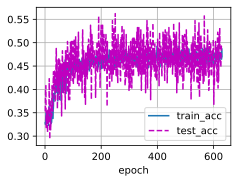

In [19]:



animator = d2l.Animator(xlabel='epoch',
                        legend=['train_acc','test_acc'])   
num_batches = len(train_dataloader)
best_train_acc=0
best_train_loss=0
best_test_acc=0
stagnate_times=0
temp_acc=0
LR=0.5

num_epochs=2000
net.to(device)
optim=torch.optim.SGD(net.parameters(),lr=LR,weight_decay=5e-4)#,weight_decay=5e-4
lr_scheduler=torch.optim.lr_scheduler.StepLR(optim,step_size=75,gamma=0.3)
loss=nn.CrossEntropyLoss()
for epoch in range(num_epochs):
    metric_train = d2l.Accumulator(2)
    net.train()
    for i,data in enumerate(train_dataloader):
        #print(data)

        optim.zero_grad()

        pddata=pd.DataFrame(data)
        x=pddata.drop(columns=['ID','KSS','LEVEL']).values
        x=torch.tensor(x).unsqueeze(1).to(torch.float32).to(device)
        # print(x.shape)
        y_hat=net(x)
        y_hat=torch.squeeze(y_hat, dim=1)
        y=torch.tensor(pddata['LEVEL'].values)-1
        y=y.long().to(device)       
        l=loss(y_hat, y)
        l.backward()
        optim.step()
        pre=torch.argmax(y_hat.detach().cpu(),dim=1)
        num_true=sum(pre==y.cpu())
        metric_train.add(num_true,y.numel())
        if (i + 1) % (num_batches // 2) == 0 or i == num_batches - 1:
            animator.add(epoch + (i + 1) / num_batches, (metric_train[0]/metric_train[1],None))
        if best_train_acc<(metric_train[0]/metric_train[1]):
            best_train_acc=metric_train[0]/metric_train[1]
            stagnate_times=0
            torch.save(net.state_dict(),os.path.join(parameterFolder,f'{best_train_acc}.pt'))
    lr_scheduler.step()
        
    net.eval()
    metric_test = d2l.Accumulator(2)
    with torch.no_grad():
        testnum_batches = len(test_dataloader)
        for data_dict in test_dataloader:

            pddata=pd.DataFrame(data)
            x=pddata.drop(columns=['ID','KSS','LEVEL']).values
            x=torch.tensor(x).unsqueeze(1).to(torch.float32).to(device)
            # print(x.shape)
            y_hat=net(x)
            y_hat=torch.squeeze(y_hat, dim=1)
            y=torch.tensor(pddata['LEVEL'].values)-1
            y=y.long().to(device)
        
            pre=torch.argmax(y_hat.detach().cpu(),dim=1)
            num_true=sum(pre==y.cpu())
            metric_test.add(num_true,y.numel())
            animator.add(epoch+ (i + 1) / num_batches, (None,metric_test[0]/metric_test[1]))

    

    
    pass
